In [347]:
import pandas as pd
import json

# Load the JSON files
with open('./data/male.json', 'r') as male_file:
    male_data = json.load(male_file)

with open('./data/female.json', 'r') as female_file:
    female_data = json.load(female_file)

with open('./data/family.json', 'r') as family_file:
    family_data = json.load(family_file)


# Convert JSON data to DataFrames
male_df = pd.DataFrame([name for _ , names in male_data.items() for name in names], columns=['Name'])
female_df = pd.DataFrame([name for _, names in female_data.items() for name in names], columns=['Name'])

# Combine male and female DataFrames into one
names_df = pd.concat([male_df, female_df], ignore_index=True)

# Create DataFrame for family names
family_df = pd.DataFrame([name for _, names in family_data.items() for name in names], columns=['Name'])

# Add a new column for the length of each name
names_df['Length'] = names_df['Name'].apply(len)
family_df['Length'] = family_df['Name'].apply(len)

# Filter out names with length less than 3 because we want to use trigram
family_df = family_df[family_df['Length'] >= 3]
family_df = family_df.reset_index(drop=True) # reset index

# # Calculate statistics for the 'Length' column in both DataFrames
# names_stats = names_df['Length'].describe()
# family_stats = family_df['Length'].describe()
# print(f"Statistics for Names DataFrame:{names_stats}")
# print(f"\nStatistics for Family Names DataFrame:{family_stats}")

# Sample 50 entries from each DataFrame for the test set
test_family_df = family_df.sample(n=50, random_state=40)
test_names_df = names_df.sample(n=50, random_state=40)

# Drop the test set samples from the original DataFrames to create the training set
train_family_df = family_df.drop(test_family_df.index).reset_index(drop=True)
train_names_df = names_df.drop(test_names_df.index).reset_index(drop=True)

# Combine the test DataFrames and the train DataFrames
train_df = pd.concat([train_family_df, train_names_df], ignore_index=True)
test_df = pd.concat([test_family_df, test_names_df], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: './data/male.json'

In [96]:
from collections import Counter
import math

# Function to generate trigrams from a name
def generate_trigrams(name):
    name = name.lower()  # without case sensitivity
    trigrams = [name[i:i+3] for i in range(len(name)-2)]  # Extract trigrams
    return trigrams

# Generate trigrams and count their occurrences for names
train_names_df['Trigrams'] = train_names_df['Name'].apply(generate_trigrams)
all_trigram_names = [trigram for trigrams in train_names_df['Trigrams'] for trigram in trigrams]
trigram_count_names = Counter(all_trigram_names)


# Generate trigrams and count their occurrences for family names
train_family_df['Trigrams'] = train_family_df['Name'].apply(generate_trigrams)
all_trigram_family = [trigram for trigrams in train_family_df['Trigrams'] for trigram in trigrams]
trigram_count_family = Counter(all_trigram_family)

# total log-probability of a name based on trigrams
# naïve Bayes is based on the simple assumption that attributes are independent of each other
def calculate_trigram_log_prob(name, trigram_counts):
    trigrams = generate_trigrams(name)
    total_trigrams = sum(trigram_counts.values()) # total amount of counted trigrams
    total_log_prob = 0
    
    for trigram in trigrams:
        # Get the count of the trigram; if not found, use a small count to avoid log(0)
        trigram_count = trigram_counts.get(trigram, 1) # avoid log from 0
        # Calculate the probability
        trigram_prob = trigram_count / total_trigrams
        # Add the negative log of the probability to the total log probability
        total_log_prob += -math.log(trigram_prob)
    return total_log_prob

name = "Hutfilz"

log_prob_name = calculate_trigram_log_prob(name, trigram_count_names)
log_prob_family = calculate_trigram_log_prob(name, trigram_count_family)

print(f"Total Log Probability for the name '{name}' in First Names: {log_prob_name}")
print(f"Total Log Probability for the name '{name}' in Family Names: {log_prob_family}")


Total Log Probability for the name 'Hutfilz' in First Names: 41.21641261524188
Total Log Probability for the name 'Hutfilz' in Family Names: 47.59487346762575


In [304]:
from collections import Counter
import math

def generate_ngrams(name, n):
    name = name.lower()
    return [name[i:i+n] for i in range(len(name)-n+1)]

def count_ngrams(df, n):
    all_ngrams = [
        ngram 
        for name in df['Name'] # iterates through each element in the Name column
        for ngram in generate_ngrams(name, n)] # generate n-grams for each name
    return Counter(all_ngrams) # A Counter object with n-grams as keys and their counts as values

def calculate_ngram_log_prob(name, ngram_counts, n):
    ngrams = generate_ngrams(name, n)
    total_ngrams = sum(ngram_counts.values())
    total_log_prob = 0
    
    for ngram in ngrams:
        ngram_count = ngram_counts.get(ngram, 1)  # Laplace smoothing observed data is not contained in our dataset therefore we need to avoid log from 0 
        ngram_prob = ngram_count / (total_ngrams + len(ngram_counts))  # Adjusted for Laplace smoothing it adds a small amount of probability to all potential n-grams
        total_log_prob += -math.log(ngram_prob)
    
    return total_log_prob

def calculate_combined_log_prob(name, ngram_counts_list):
    total_log_prob = 0
    for n, ngram_counts in enumerate(ngram_counts_list, start=1):
        if len(name) >= n:
            total_log_prob += calculate_ngram_log_prob(name, ngram_counts, n)
    return total_log_prob

def classify_name(name, ngram_counts_names, ngram_counts_family):
    log_prob_name = calculate_combined_log_prob(name, ngram_counts_names)
    log_prob_family = calculate_combined_log_prob(name, ngram_counts_family)
    
    print(f"Combined Log Probability for '{name}' as a First Name: {log_prob_name}")
    print(f"Combined Log Probability for '{name}' as a Family Name: {log_prob_family}")
    
    if log_prob_name < log_prob_family:
        return "First Name"
    else:
        return "Family Name"

# Generate n-gram counts for n=1,2,3,4 for both first names and family names
ngram_counts_names = [count_ngrams(train_names_df, n) for n in range(1, 4)]
ngram_counts_family = [count_ngrams(train_family_df, n) for n in range(1, 4)]
name = "Vroni"
classification = classify_name(name, ngram_counts_names, ngram_counts_family)
print(f"The name '{name}' is classified as a {classification}")

Combined Log Probability for 'Vroni' as a First Name: 60.43782115227893
Combined Log Probability for 'Vroni' as a Family Name: 72.78062612300016
The name 'Vroni' is classified as a First Name


Classification accuracy: 83.00%
False Positives (First Name predicted as Family Name):
Index: 54 Name: Henning
Index: 58 Name: Rachel
Index: 66 Name: Uschi
Index: 70 Name: Zeno
Index: 71 Name: Roberto
Index: 73 Name: Meinrad
Index: 75 Name: Bertha
Index: 78 Name: Folkert
Index: 81 Name: Ulfert
False Negatives (Family Name predicted as First Name):
Index: 18 Name: Medardt
Index: 22 Name: Bruyns
Index: 38 Name: Karen
Index: 40 Name: Nimps
Index: 43 Name: Heijdemann
Index: 45 Name: Hutfilz
Index: 46 Name: Moringen
Index: 50 Name: Yasmin


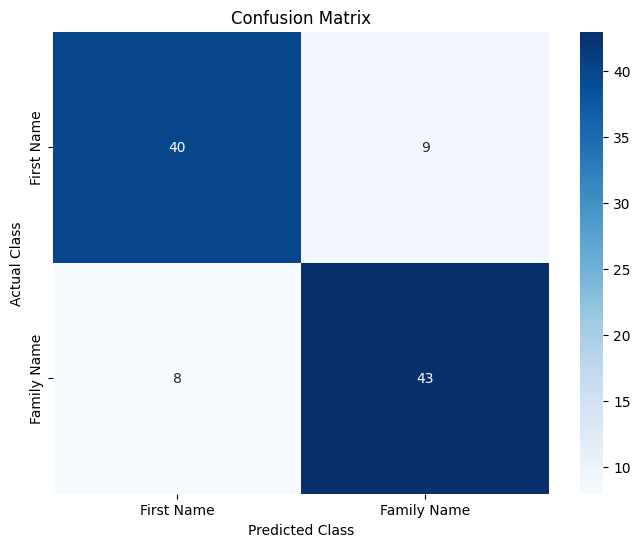

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
    
def get_confusion_matrix(test_df, ngram_counts_names, ngram_counts_family):
    y_true = []
    y_pred = []
    false_positives = []
    false_negatives = []
    
    for index, row in test_df.iterrows():
        # Determine actual class
        actual_class = "First Name" if index > 50 else "Family Name"
        y_true.append(actual_class)
        
        # Predict the class using classify_name function
        predicted_class = classify_name(row['Name'], ngram_counts_names, ngram_counts_family)
        y_pred.append(predicted_class)
        
        # Check for false positives and false negatives
        if actual_class == "Family Name" and predicted_class == "First Name":
            false_negatives.append((index, row['Name']))
        elif actual_class == "First Name" and predicted_class == "Family Name":
            false_positives.append((index, row['Name']))
    
    # Generate confusion matrix
    labels = ["First Name", "Family Name"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Print false positives and false negatives
    print("False Positives (First Name predicted as Family Name):")
    for index, name in false_positives:
        print(f"Index: {index} Name: {name}")
    print("False Negatives (Family Name predicted as First Name):")
    for index, name in false_negatives:
        print(f"Index: {index} Name: {name}")
    
    return cm
          
          
def assess_accuracy(test_df, ngram_counts_names, ngram_counts_family):
    correct_predictions = 0
    
    for index, row in test_df.iterrows():
        actual_class = "First Name" if index > 50 else "Family Name"  # First 50 are names, next 50 are family names
        predicted_class = classify_name(row['Name'], ngram_counts_names, ngram_counts_family)
        
        if predicted_class == actual_class:
            correct_predictions += 1
    
    accuracy = correct_predictions / len(test_df)
    return accuracy

# Classify each name in the test set and assess accuracy
accuracy = assess_accuracy(test_df, ngram_counts_names, ngram_counts_family)

print(f"Classification accuracy: {accuracy:.2%}")

# Get the confusion matrix
cm = get_confusion_matrix(test_df, ngram_counts_names, ngram_counts_family)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["First Name", "Family Name"], yticklabels=["First Name", "Family Name"])
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()



We are developing a model to classify whether a given name is a first name, last name. To enhance the accuracy of the model, 
we're not only analyzing the names themselves but also extracting features from the structure and format of the name entity. 
This table is designed to systematically organize and summarize the different possible name configurations and the structural 
features that can be extracted from them. By laying out these patterns, we can identify key indicators that the model can use to make more accurate predictions about whether a name is a first name, last name.

| **Category**                       | **Format**                        | **Example**                       | **Notes**                                            |
|------------------------------------|-----------------------------------|-----------------------------------|------------------------------------------------------|
| **1. Standard Formats**            |                                   |                                   |                                                      |
| - Full Name                        | First Last                        | Beate Albers                      | Most common Western format                           |
| - Reverse Order                    | Last, First                       | Albers, Beate                     | Common in formal or alphabetized lists               |
| - Initial and Last Name            | F. Last                           | B. Albers                         | Common in informal or space-constrained contexts     |
| - Full Name with Middle Initial    | First M. Last                     | Beate S. Albers                   | Commonly used in formal contexts                     |
| - Full Name with Middle Name       | First Middle Last                 | Beate Susanne Albers              | Less common, but used in formal documents            |
| **2. Abbreviated Formats**         |                                   |                                   |                                                      |
| - Initials and Last Name           | F.M. Last                         | B.S. Albers                       | Used in formal or academic contexts                  |
| - Last Name and Initials           | Last, F.M.                        | Albers, B.S.                      | Sometimes used in bibliographies                     |
| - All Initials                     | F.M.L.                            | B.S.A.                            | Rare, but possible in very informal contexts         |
| **3. Nickname Variations**         |                                   |                                   |                                                      |
| - Nickname in Quotes               | First "Nickname" Last             | Beate "Bibi" Albers               | Common way to indicate a known nickname              |
| - Nickname in Parentheses          | First (Nickname) Last             | Beate (Bibi) Albers               | Alternative way to show nicknames                    |
| - Nickname Replacing First Name    | Nickname Last                     | Bibi Albers                       | When nickname is commonly used instead of first name |
| **4. Professional Titles**         |                                   |                                   |                                                      |
| - Title Before Name                | Title First Last                  | Dr. Beate Albers                  | Common for academic or professional titles           |
| - Title After Name                 | First Last, Title                 | Beate Albers, PhD                 | Alternative format for titles                        |
| **5. Cultural Variations**         |                                   |                                   |                                                      |
| - Middle Name as Initial           | First M Last                      | Beate S Albers                    | Without period after initial                         |
| - Double Last Name (No Hyphen)     | First LastA LastB                 | Beate Albers Schmitt              | Common in some cultures (e.g., Spanish)              |
| - Double Last Name (Hyphenated)    | First LastA-LastB                 | Beate Albers-Schmitt              | Used when last names are officially combined         |
| **6. Formatting Variations**       |                                   |                                   |                                                      |
| - All Caps                         | FIRST LAST                        | BEATE ALBERS                      | Used for emphasis or in certain document types       |
| - Lower Case                       | first last                        | beate albers                      | Might appear in informal digital communications      |
| - Camel Case                       | FirstLast                         | BeateAlbers                       | Sometimes used in digital contexts or usernames      |
| - Typo                             | Frist Last                        | Baete Albers                      | Edge case                                            |
| **7. Incomplete or Partial Names** |                                   |                                   |                                                      |
| - Last Name Only                   | Last                              | Albers                            | Common in informal speech or when last name is known |
| - First Name Only                  | First                             | Beate                             | Used in informal contexts or when first name suffices|
| **8. International Formats**       |                                   |                                   |                                                      |
| - Eastern Order                    | Last First                        | Albers Beate                      | Common in some Asian countries (without comma)       |
| - Patronymic                       | First Patronymic Last             | Beate Karlsdotter Albers          | Used in some Scandinavian naming traditions          |
| - Prefix                           | Prefix Last                       | von Albers                        | Often indicates Last Name in certain cultures        |
| - Suffix                           | First Last Suffix                 | Beate Albers Jr.                  | Indicates generation or lineage                      |

Features Machine Learning:

seqeunce_length: int
absolute_position: int
absolute_position/seqeunce_length: [1/3]

char_length: int

has_hyphen: binary
has_period: binary
has_comma: binary
special_char: binary

1,2,3,4-gram probabilty or one hot encoded top 100 n grams?
